# **Dimensionality Reduction in High-Dimensional Data: PCA vs t-SNE on a Synthetic 50D Dataset**

In this notebook, I generate a synthetic high-dimensional dataset with multiple Gaussian clusters and use it to compare:

- Principal Component Analysis (PCA) – a linear dimensionality reduction method.
- t-distributed Stochastic Neighbor Embedding (t-SNE) – a nonlinear, manifold-learning method.

The goals are to:

- Create a controlled 50-dimensional dataset with clear cluster structure.
- Visualise the data in 2D using PCA and t-SNE.
- Quantitatively compare the embeddings using silhouette scores.
- Build intuition about when PCA and t-SNE provide useful representations.

In [1]:
# Cell 1 – Imports and configuration

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid", context="notebook")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# **Generate a Synthetic 50-Dimensional Dataset**

In this section, I generate a synthetic dataset with:

- 4 classes (clusters),
- 50 continuous features,
- 400 samples per class (1600 samples in total).

Each class is sampled from a multivariate Gaussian distribution with a distinct mean vector in 50D space. A diagonal covariance structure is used with random scales per feature to introduce variability while preserving numerical stability.


In [2]:
# Cell 2 – Generate synthetic 50-dimensional Gaussian clusters

n_classes = 4
n_features = 50
samples_per_class = 400

means = []
covs = []

for k in range(n_classes):
    # Random mean vector, scaled for separation between clusters
    mean_k = np.random.randn(n_features) * 3.0 + k * 5.0
    means.append(mean_k)
    
    # Random positive diagonal covariance with reasonable scale
    var_k = np.abs(np.random.randn(n_features)) + 0.5
    cov_k = np.diag(var_k)
    covs.append(cov_k)

X_list = []
y_list = []

for k in range(n_classes):
    X_k = np.random.multivariate_normal(mean=means[k], cov=covs[k], size=samples_per_class)
    y_k = np.full(samples_per_class, k, dtype=int)
    X_list.append(X_k)
    y_list.append(y_k)

X = np.vstack(X_list)
y = np.concatenate(y_list)

X.shape, y.shape


((1600, 50), (1600,))

# **Create a DataFrame and Inspect the Dataset**

I now wrap the generated data into a pandas DataFrame with:

- 50 feature columns named `f1`, `f2`, ..., `f50`
- A target column `class_label` taking values 0, 1, 2, or 3.

I then inspect the first few rows and basic summary statistics.


In [3]:
# Cell 3 – Wrap into a DataFrame

feature_cols = [f"f{i}" for i in range(1, n_features + 1)]
data = pd.DataFrame(X, columns=feature_cols)
data["class_label"] = y

print("Shape of dataset:", data.shape)
data.head()


Shape of dataset: (1600, 51)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f42,f43,f44,f45,f46,f47,f48,f49,f50,class_label
0,2.968585,-2.069394,4.178689,4.306592,-0.065927,0.826152,3.871456,1.060817,-0.754214,0.261555,...,-1.345052,-0.272919,-0.835903,-3.435868,-1.286761,-1.431479,3.506420,0.278058,-5.317142,0
1,0.903190,0.638490,1.644673,2.971532,-2.184637,-0.446414,4.481922,1.329384,-1.222918,1.670515,...,-0.333876,-0.978261,-2.197220,-1.527518,-3.270549,-0.595268,3.164411,0.048081,-4.020689,0
2,0.709067,-1.265563,0.131994,3.870445,-1.730624,-1.788185,5.611812,1.956373,-2.512551,1.566655,...,0.224529,0.476862,-0.860190,-4.190254,-2.842119,-1.896651,3.900412,0.601595,-6.257370,0
3,1.073139,0.661237,1.963047,4.913789,-1.223359,-1.092453,4.265395,1.537816,0.661850,4.148711,...,1.569801,-0.732338,-0.677490,-5.832113,-2.736677,-2.145762,3.233800,1.299007,-5.698511,0
4,2.237409,0.614609,1.085511,6.553422,1.148649,-2.048902,4.887179,2.368258,-1.797626,1.560160,...,0.853392,-0.101482,-2.408832,-4.382933,0.470336,-2.537458,2.878433,1.525658,-3.858635,0


In [4]:
# Cell 4 – Basic info and summary statistics

print("Dataset info:\n")
print(data.info())

print("\nSummary statistics for the first 10 features:\n")
display(data[feature_cols[:10]].describe())


Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 51 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   f1           1600 non-null   float64
 1   f2           1600 non-null   float64
 2   f3           1600 non-null   float64
 3   f4           1600 non-null   float64
 4   f5           1600 non-null   float64
 5   f6           1600 non-null   float64
 6   f7           1600 non-null   float64
 7   f8           1600 non-null   float64
 8   f9           1600 non-null   float64
 9   f10          1600 non-null   float64
 10  f11          1600 non-null   float64
 11  f12          1600 non-null   float64
 12  f13          1600 non-null   float64
 13  f14          1600 non-null   float64
 14  f15          1600 non-null   float64
 15  f16          1600 non-null   float64
 16  f17          1600 non-null   float64
 17  f18          1600 non-null   float64
 18  f19          1600 non-null   floa

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,6.499407,7.113171,9.122416,9.248480,6.180922,6.963009,11.449518,8.130442,8.166610,10.629388
std,5.477455,5.779133,6.461804,5.990128,5.685007,5.829948,5.149575,4.553374,6.807231,7.906348
min,-1.842507,-3.403398,-2.312191,-1.228130,-3.456689,-3.941611,1.476168,-0.216438,-4.325309,-2.852652
25%,1.152898,1.636375,3.049301,3.410182,2.268965,3.086889,7.512484,3.884792,1.895077,3.453891
50%,5.914257,6.854904,7.586883,8.597478,5.055816,6.770519,11.111879,8.477996,8.855936,9.559027
75%,11.977776,12.477255,15.640766,15.274143,10.284748,10.362922,16.487547,12.536546,13.641094,17.704730
max,14.960429,17.486477,20.401024,19.670422,17.484763,18.540427,21.018788,16.427283,19.767139,24.497777


# **Class Distribution**

The following plot shows the number of samples in each synthetic class. Because the dataset was generated with a fixed number of samples per class, the distribution is balanced by design.


Class distribution:
 class_label
0    400
1    400
2    400
3    400
Name: count, dtype: int64


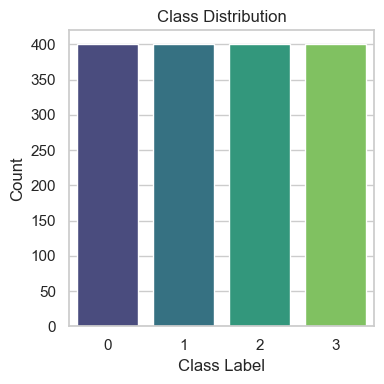

In [5]:
# Cell 5 – Class distribution

class_counts = data["class_label"].value_counts().sort_index()
print("Class distribution:\n", class_counts)

plt.figure(figsize=(4, 4))
sns.countplot(x="class_label", data=data, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# **Initial Visualisation of Selected Features**

Although the dataset is 50-dimensional, it is useful to inspect a few features directly:

- I select the first three features `f1`, `f2`, and `f3`.
- I visualise their pairwise relationships coloured by class label.

This is not representative of the full 50D structure but gives an impression of cluster separation in a low-dimensional subspace.


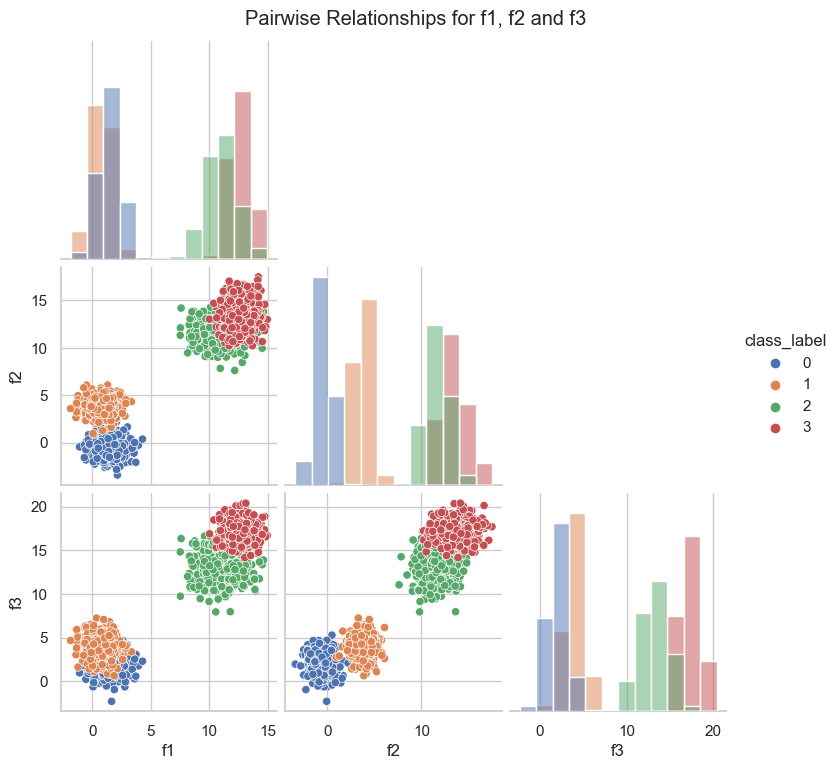

In [6]:
# Cell 6 – Pairplot for a subset of features

subset_features = ["f1", "f2", "f3", "class_label"]
subset_df = data[subset_features].copy()
subset_df["class_label"] = subset_df["class_label"].astype(str)

sns.pairplot(
    subset_df,
    vars=["f1", "f2", "f3"],
    hue="class_label",
    corner=True,
    diag_kind="hist"
)
plt.suptitle("Pairwise Relationships for f1, f2 and f3", y=1.02)
plt.show()


# **Correlation Structure for a Subset of Features**

To understand redundancy and structure in the features, I compute and visualise the correlation matrix for the first 15 features. This helps to illustrate the extent to which PCA can exploit correlated directions in the data.


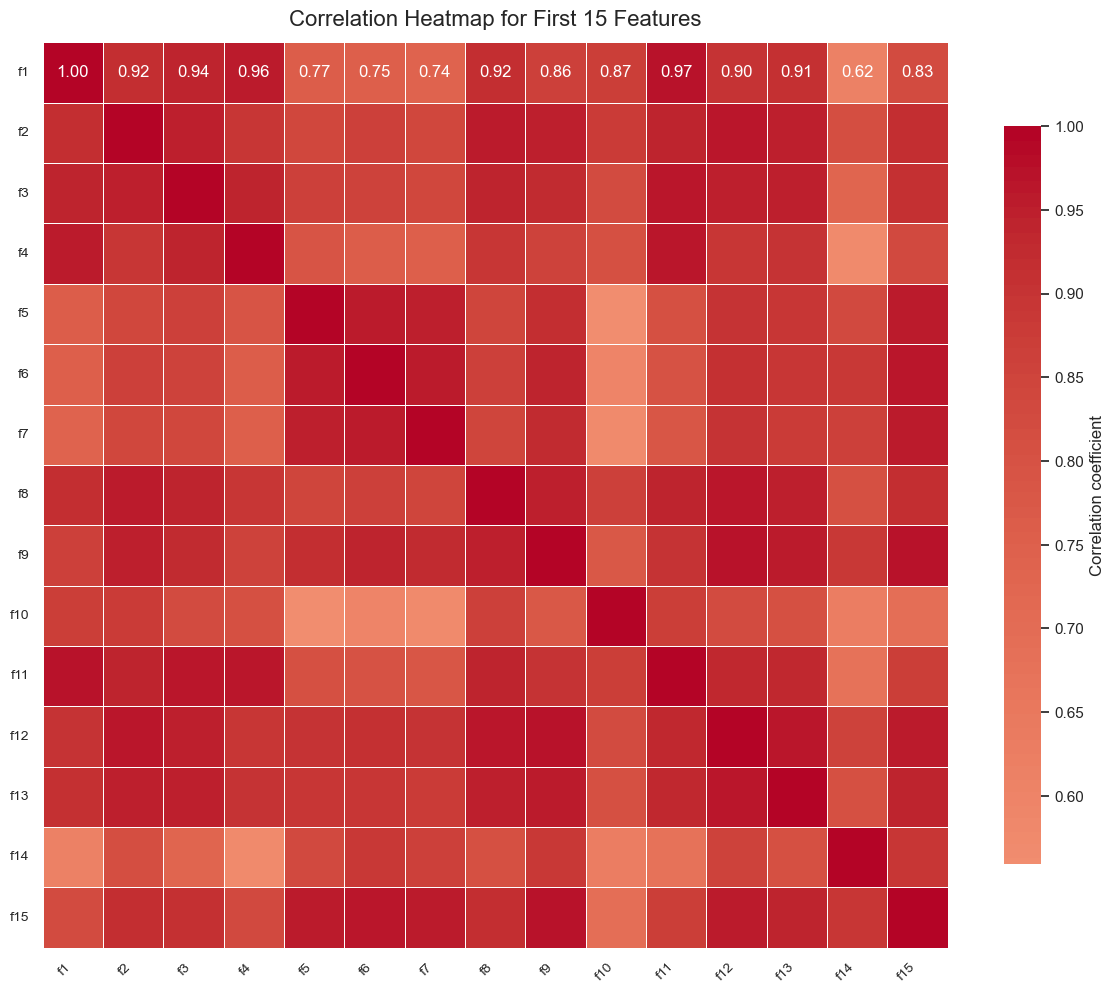

In [8]:
# Cell 7 – Correlation heatmap for a subset of features

subset_corr_features = feature_cols[:15]
corr = data[subset_corr_features].corr()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation coefficient"}
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.title("Correlation Heatmap for First 15 Features", fontsize=16, pad=12)
plt.tight_layout()
plt.show()


# **Standardisation of Features**

Before applying PCA or t-SNE, it is important to standardise the features so that:

- Each feature has zero mean and unit variance.
- No single feature dominates the distance calculations due to scale differences.

Here I apply standardisation to all 50 features.


In [9]:
# Cell 8 – Standardise the 50D feature space

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[feature_cols].values)

X_scaled.shape


(1600, 50)

# **PCA: Fitting and Explained Variance**

In this section, I:

- Fit PCA with `n_components = 50` on the standardised data.
- Examine the explained variance ratio for each principal component.
- Compute the cumulative explained variance to see how many components are required to capture most of the variation in the data.


In [10]:
# Cell 9 – Fit PCA with all components

pca = PCA(n_components=n_features, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("First 10 explained variance ratios:\n", explained_variance_ratio[:10])
print("\nTotal variance explained by 50 components:", cumulative_variance[-1])


First 10 explained variance ratios:
 [0.86335765 0.06053399 0.04321122 0.00207958 0.00150735 0.00128664
 0.00123083 0.00115883 0.001091   0.00101928]

Total variance explained by 50 components: 0.9999999999999998


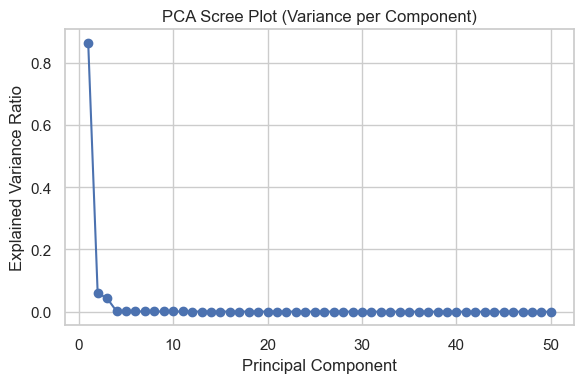

In [11]:
# Cell 10 – Scree plot of explained variance per component

plt.figure(figsize=(6, 4))
plt.plot(range(1, n_features + 1), explained_variance_ratio, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot (Variance per Component)")
plt.tight_layout()
plt.show()


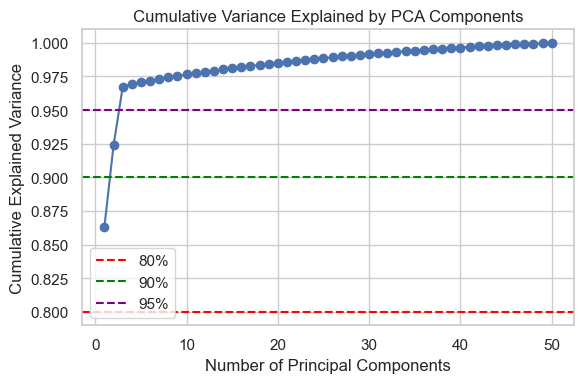

In [12]:
# Cell 11 – Cumulative explained variance plot

plt.figure(figsize=(6, 4))
plt.plot(range(1, n_features + 1), cumulative_variance, marker="o")
plt.axhline(0.80, color="red", linestyle="--", label="80%")
plt.axhline(0.90, color="green", linestyle="--", label="90%")
plt.axhline(0.95, color="purple", linestyle="--", label="95%")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained by PCA Components")
plt.legend()
plt.tight_layout()
plt.show()


# **PCA: 2D Visualisation**

To visualise cluster structure, I project the data onto the first two principal components:

- PC1 and PC2 together capture the largest share of total variance.
- I create a scatter plot in the PC1–PC2 plane, coloured by class label.

This gives a linear, global view of how the classes are separated in the principal subspace.


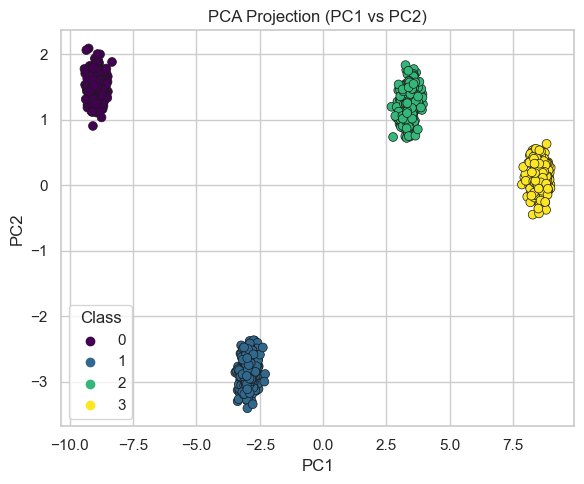

In [13]:
# Cell 12 – 2D PCA scatter plot

pca_2d_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "class_label": y
})

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="class_label",
    data=pca_2d_df,
    palette="viridis",
    s=40,
    edgecolor="k"
)
plt.title("PCA Projection (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


# **t-SNE: Overview and Configuration**

t-SNE is a nonlinear dimensionality reduction method designed for visualisation. It:

- Constructs probability distributions over pairs of points in the high-dimensional space.
- Seeks a 2D embedding whose pairwise similarities match the original as closely as possible.
- Uses a Student-t distribution in the low-dimensional space to handle crowding.

Key hyperparameters include:

- Perplexity (related to effective number of neighbours).
- Learning rate.
- Number of iterations.

Here I fit t-SNE with two different perplexity values to study the effect on the embedding.


In [14]:
# Cell 13 – t-SNE with perplexity = 30

tsne_30 = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    metric="euclidean",
    random_state=RANDOM_STATE,
    init="random"
)

X_tsne_30 = tsne_30.fit_transform(X_scaled)
X_tsne_30.shape


(1600, 2)

In [15]:
# Cell 14 – t-SNE with perplexity = 50

tsne_50 = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=200,
    n_iter=1000,
    metric="euclidean",
    random_state=RANDOM_STATE,
    init="random"
)

X_tsne_50 = tsne_50.fit_transform(X_scaled)
X_tsne_50.shape


(1600, 2)

# **t-SNE: 2D Visualisation for Perplexity 30**

This section plots the 2D t-SNE embedding for perplexity 30. The main expectation is that:

- Each synthetic Gaussian cluster will form a tight group.
- The relative spacing between clusters may differ from the PCA projection, as t-SNE focuses more on preserving local neighbourhoods than global geometry.


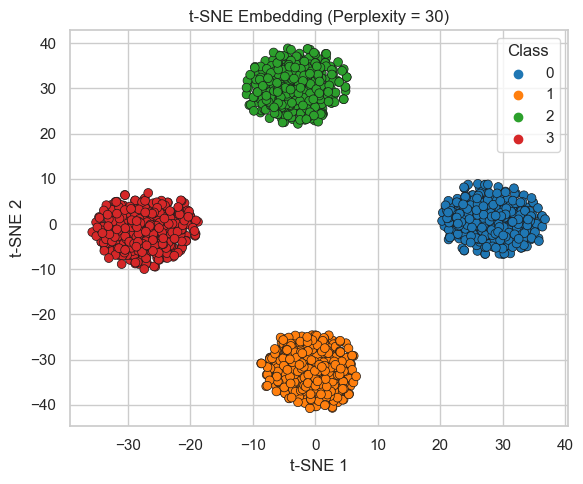

In [16]:
# Cell 15 – t-SNE scatter plot (perplexity = 30)

tsne30_df = pd.DataFrame({
    "TSNE1": X_tsne_30[:, 0],
    "TSNE2": X_tsne_30[:, 1],
    "class_label": y
})

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="class_label",
    data=tsne30_df,
    palette="tab10",
    s=40,
    edgecolor="k"
)
plt.title("t-SNE Embedding (Perplexity = 30)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


# **t-SNE: 2D Visualisation for Perplexity 50**

Here I visualise the embedding produced when the perplexity is increased to 50. Changing perplexity affects the balance between local and global structure in the visualisation, so the cluster layout may differ from the previous t-SNE plot.


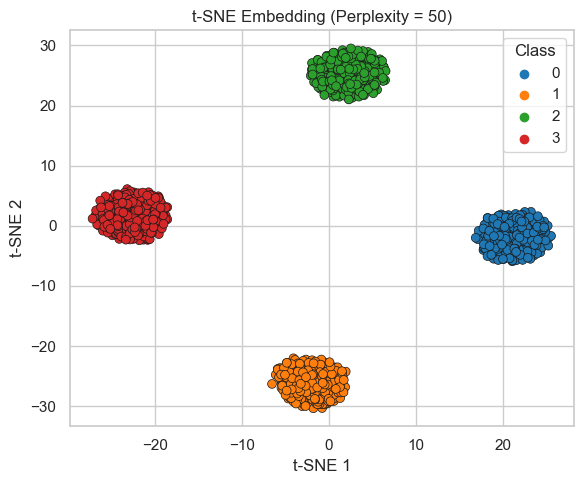

In [17]:
# Cell 16 – t-SNE scatter plot (perplexity = 50)

tsne50_df = pd.DataFrame({
    "TSNE1": X_tsne_50[:, 0],
    "TSNE2": X_tsne_50[:, 1],
    "class_label": y
})

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="class_label",
    data=tsne50_df,
    palette="tab10",
    s=40,
    edgecolor="k"
)
plt.title("t-SNE Embedding (Perplexity = 50)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


# **Quantitative Comparison Using Silhouette Scores**

To compare PCA and t-SNE more systematically, I use the silhouette score, which measures how well samples are matched to their own cluster relative to other clusters.

Here I compute silhouette scores for:

- The 2D PCA embedding (PC1 and PC2).
- The t-SNE embedding with perplexity 30.
- The t-SNE embedding with perplexity 50.

Even though I know the true labels, I treat them as cluster labels to assess how cleanly each embedding separates the synthetic classes.


In [18]:
# Cell 17 – Silhouette scores for PCA and t-SNE embeddings

# Use only the first two PCA components for fair comparison
X_pca_2d = X_pca[:, :2]

sil_pca = silhouette_score(X_pca_2d, y)
sil_tsne30 = silhouette_score(X_tsne_30, y)
sil_tsne50 = silhouette_score(X_tsne_50, y)

print(f"Silhouette Score – PCA (2D):      {sil_pca:.4f}")
print(f"Silhouette Score – t-SNE (p=30):  {sil_tsne30:.4f}")
print(f"Silhouette Score – t-SNE (p=50):  {sil_tsne50:.4f}")


Silhouette Score – PCA (2D):      0.9444
Silhouette Score – t-SNE (p=30):  0.8317
Silhouette Score – t-SNE (p=50):  0.8953


# **Summary of Embedding Metrics**

I now summarise the silhouette scores into a small comparison table, which can be directly reused in the written report.


In [19]:
# Cell 18 – Create a summary table of embedding metrics

embedding_summary = pd.DataFrame({
    "Method": ["PCA (PC1–PC2)", "t-SNE (perplexity = 30)", "t-SNE (perplexity = 50)"],
    "Dimensionality": [2, 2, 2],
    "Perplexity": [None, 30, 50],
    "Silhouette_Score": [sil_pca, sil_tsne30, sil_tsne50]
})

embedding_summary


,Method,Dimensionality,Perplexity,Silhouette_Score
0,PCA (PC1–PC2),2,NaN,0.944396
1,t-SNE (perplexity = 30),2,30.0,0.831655
2,t-SNE (perplexity = 50),2,50.0,0.895341
